In [1]:
#basic imports ✌

import matplotlib.pyplot as plt
import os
import random
import numpy as np
import math, random
import tensorflow as tf
#os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras as ks
import soundfile as sf
import sounddevice as sd
import python_speech_features

%matplotlib inline
np.random.seed(0)

Using TensorFlow backend.


In [2]:
#Finding speech sample 🤷‍🤷‍🤷‍
class speech:
    
    def choose_random(self):
        path = r"C:\Users\Darius\Desktop\sound samples\training data for RNN\LibriSpeech\train-clean-100"
        for i in range (0,3):
            files = os.listdir(path)
            index = random.randrange(0, len(files))
            while  files[index].endswith('.txt'):
                #index = index + 1
                index = random.randrange(0, len(files))
            path  = os.path.join(path, files[index])
        file_path = path
        self.sample, fs2 = sf.read(file_path)
        
        self.size = len(self.sample)
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)

    def show_sample(self):
        print(file_path)
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [3]:
#Finding noise sample 🎉🎉🎉🎉🎷🎸🎶🎵🎵
class noise:
    def __init__(self,size):
        self.size = size
    
    def choose_random(self):
        path = r"C:\Users\Darius\Desktop\sound samples\training data for RNN\rnnoise_contributions"
        files = os.listdir(path)
        index = random.randrange(0, len(files))
        if  files[index].endswith('.txt'):
            index = index -1
        file_path = os.path.join(path, files[index])
        self.sample, fs = sf.read(file_path, channels=2, samplerate=24100,format='RAW', subtype='PCM_16')

        i=0
        while i!=1:
            random_sequence = random.randrange(0,len(self.sample))
            if random_sequence + self.size < len(self.sample):
                i=1
        self.sample = self.sample[random_sequence:]
        self.sample = self.sample[:self.size ,:1]
        
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)
        
    def show_sample():
        print(file_path)
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [4]:
#making input sample  🎵🎵🤷‍🤷‍
class combined_samples:
    def __init__(self,speech_sample,noise_sample):
        self.speech_sample = speech_sample
        self.noise_sample  = noise_sample
    
    def combine_samples(self):
        self.sample = [len(self.speech_sample)] * 0
        self.sample = np.empty([len(self.speech_sample)])

        for i in range(len(self.speech_sample)):
            self.sample[i] = self.speech_sample[i] + self.noise_sample[i]
        
        self.size = len(self.sample)
        self.nfcc = python_speech_features.mfcc(self.sample,18000,0.025,0.01,24)
        
    def show_sample(self):
        plt.plot(self.sample)
    def listen_sample(self):
        sd.play(self.sample) 

In [5]:
# Training Data
class training_data:
    def get_data(self):
        self.speechD = speech()
        self.speechD.choose_random()
        
        self.noiseD = noise(self.speechD.size)
        self.noiseD.choose_random()
        
        self.combined = combined_samples(self.speechD.sample , self.noiseD.sample)
        self.combined.combine_samples()
        
        self.input = self.combined.nfcc
        self.output= self.speechD.nfcc

In [6]:
d = training_data()
d.get_data()

In [7]:
#Creating The GRU NN
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Activation, GRU, Flatten, Embedding

input_dim = 24
max_dim = 2000

model = Sequential()

model.add(GRU(input_dim,input_shape=(None,input_dim),activation='tanh',return_sequences=True))

model.add(Dropout(0.15))

model.add(GRU(input_dim,input_shape=(None,input_dim),activation='tanh', return_sequences=True))
model.add(Dropout(0.15))

model.add(Dense(units=input_dim))
model.add(Activation("linear"))


model.build()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [8]:
model.summary()

logs_dir= './event_logs_new'
tbCallBack=ks.callbacks.TensorBoard(log_dir='./event_logs_new', histogram_freq=0,
                            write_graph=True, write_images=True)

from keras.utils.vis_utils import plot_model
os.environ["PATH"] += os.pathsep + r"\\Users\\Darius\\Desktop\\RNN stuff\\graphviz\\"
import pydot_ng as pydot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 24)          3528      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 24)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 24)          3528      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 24)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 24)          600       
_________________________________________________________________
activation_1 (Activation)    (None, None, 24)          0         
Total params: 7,656
Trainable params: 7,656
Non-trainable params: 0
_________________________________________________________________


In [84]:
#Training the NN
import progressbar
from tqdm import tqdm
from IPython.display import clear_output
n_epochs = 50
history=['0']
for i in tqdm(range(n_epochs)):
    #model.train_on_batch(d.input,d.output)
    #model.fit(d.input,d.output,callbacks=[tbCallBack],epochs=5,batch_size=10)
    model.train_on_batch(np.expand_dims(d.input,axis=0),np.expand_dims(d.output,axis=0))
    if i%10==0 :
        clear_output(wait=True)
        print("Training Epoch {}".format(i))
        score= model.evaluate(np.expand_dims(d.input,axis=0),np.expand_dims(d.output,axis=0))
        
        print(score)
        history.append(score)
        
    #if i%50==0 :    
        d.get_data()
    
del history[0:1]

Training Epoch 40
1/1 [==============================] - 1s 584ms/step
[175.98497009277344, 0.48712122440338135]



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.93s/it]


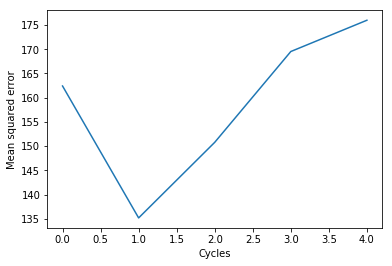

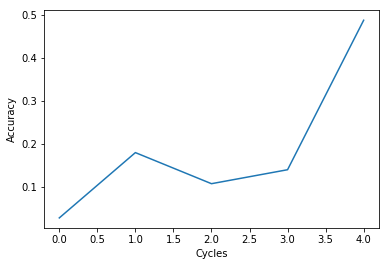

In [85]:
#Check how the NN is doing 
loss = [l[0] for l in history]
accuracy = [l[1] for l in history]

plt.plot(loss)
plt.xlabel('Cycles')
plt.ylabel('Mean squared error')
plt.savefig("error.png")
plt.show()
plt.plot(accuracy)
plt.xlabel('Cycles')
plt.ylabel('Accuracy')
plt.savefig("accuracy.png")

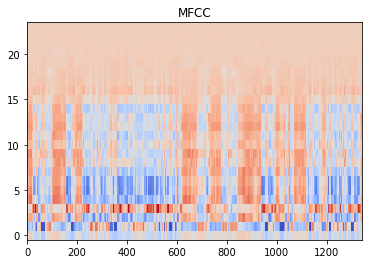

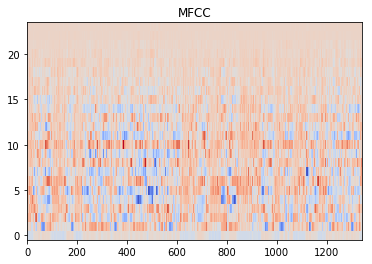

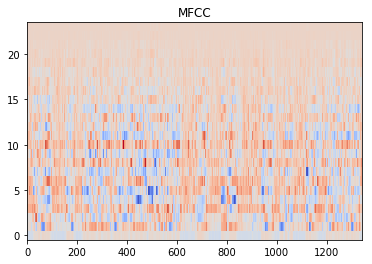

In [30]:
#predictions
pred= model.predict(np.expand_dims(d.input,axis=0))
pred= np.squeeze(pred, axis=0)
from matplotlib import cm
#Plotting the MFCC diagrams
fig,ax=plt.subplots()
mfcc_data=np.swapaxes(pred,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.show()


fig,ax=plt.subplots()
mfcc_data=np.swapaxes(d.output,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.show()


fig,ax=plt.subplots()
mfcc_data=np.swapaxes(d.input,0,1)

cax=ax.imshow(mfcc_data,interpolation='nearest',cmap=cm.coolwarm,origin='lower',aspect='auto')
ax.set_title('MFCC')
plt.show()

In [23]:
model.save('my_model.h5')

In [25]:
score= model.evaluate(np.expand_dims(d.input,axis=0),np.expand_dims(d.output,axis=0))

print(score)

1/1 [==============================] - 1s 584ms/step
[101.06051635742188, 0.17313432693481445]


In [28]:
Prediction=model.predict(np.expand_dims(d.input,axis=0))
print(Prediction)
Prediction.shape

[[[-0.95786023 -3.8316019   1.0448074  ... -0.04131719  0.00819611
   -0.04993513]
  [-0.87169814 -5.0794463   1.9356959  ... -0.03893114  0.04094901
   -0.0521542 ]
  [-0.766798   -5.4925933   2.158474   ... -0.02716053  0.06006389
   -0.0509106 ]
  ...
  [-0.9424772  -3.3716023   3.120957   ... -0.19316113 -0.07078583
   -0.07117876]
  [-1.0127501  -3.704049    2.609818   ... -0.23487997 -0.02657641
   -0.09712419]
  [-0.54889596 -3.9876292   3.2062387  ... -0.17034513  0.02100711
   -0.08951511]]]


(1, 1340, 24)

In [9]:
nrSamples=8000
asta=np.zeros(shape=(nrSamples,2000,24))
asta2=np.zeros(shape=(nrSamples,2000,24))
for i in range(nrSamples):
    for j in range(len(d.input)):
        for h in range(len(d.input[j])):
            asta[i][j][h]=d.input[j][h]
            asta2[i][j][h]=d.output[j][h]
    if(i%100==0):
        print(i)
    d.get_data()
            

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


KeyboardInterrupt: 

In [20]:
model.fit(asta,asta2,callbacks=[tbCallBack],epochs=10,batch_size=10)

Epoch 1/10
400/400 [==============================] - 183s 457ms/step - loss: 75.9121 - acc: 0.0645
Epoch 2/10
400/400 [==============================] - 176s 439ms/step - loss: 72.8248 - acc: 0.1003
Epoch 3/10
400/400 [==============================] - 175s 437ms/step - loss: 70.5292 - acc: 0.1150
Epoch 4/10
400/400 [==============================] - 174s 435ms/step - loss: 68.6559 - acc: 0.1226
Epoch 5/10
400/400 [==============================] - 175s 437ms/step - loss: 67.0217 - acc: 0.1286
Epoch 6/10
400/400 [==============================] - 174s 435ms/step - loss: 65.5744 - acc: 0.1345
Epoch 7/10
400/400 [==============================] - 175s 437ms/step - loss: 64.2725 - acc: 0.1392
Epoch 8/10
400/400 [==============================] - 176s 441ms/step - loss: 63.0740 - acc: 0.1457
Epoch 9/10
400/400 [==============================] - 170s 426ms/step - loss: 61.9687 - acc: 0.1506
Epoch 10/10
400/400 [==============================] - 181s 452ms/step - loss: 60.9315 - acc: 0.1564

In [ ]:
def DataGenerator(batch_size):
    batch_inputs = np.zeros(shape=(batch_size,2000,24))
    batch_outputs= np.zeros(shape=(batch_size,2000,24))
    while True:
        for i in range(batch_size):
            d.get_data()
            for j in range(len(d.input)):
                for h in range(len(d.input[j])):
                    batch_inputs[i][j][h] = d.input[j][h]
                    batch_outputs[i][j][h]= d.output[j][h]
        print ("pula mea")
        yield batch_inputs , batch_outputs

In [ ]:
model.fit_generator(DataGenerator(10),callbacks=[tbCallBack],verbose=2,epochs=10,steps_per_epoch=10)

Epoch 1/10
